# Artificial Intelligence of Things - Demonstration

This document describes methods and mechanisms for the execution of
Artificial Neural Networks in devices with low computational power.

## Load dataset

In [1]:
import src.dataset.yalefaces as yalefaces
import numpy as np

np.random.seed(99)

In [2]:
import numpy as np
X, y = yalefaces.load("data/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

print(f"Loaded {int(X.shape[0]/len(np.unique(y)))} faces from {len(np.unique(y))} individuals,"
f" a total of {X.shape[0]} images of size {yalefaces.SHAPE} ({X[0].shape[0]} pixels).")

Loaded 11 faces from 15 individuals, a total of 165 images of size (243, 320) (77760 pixels).


<Figure size 640x480 with 0 Axes>

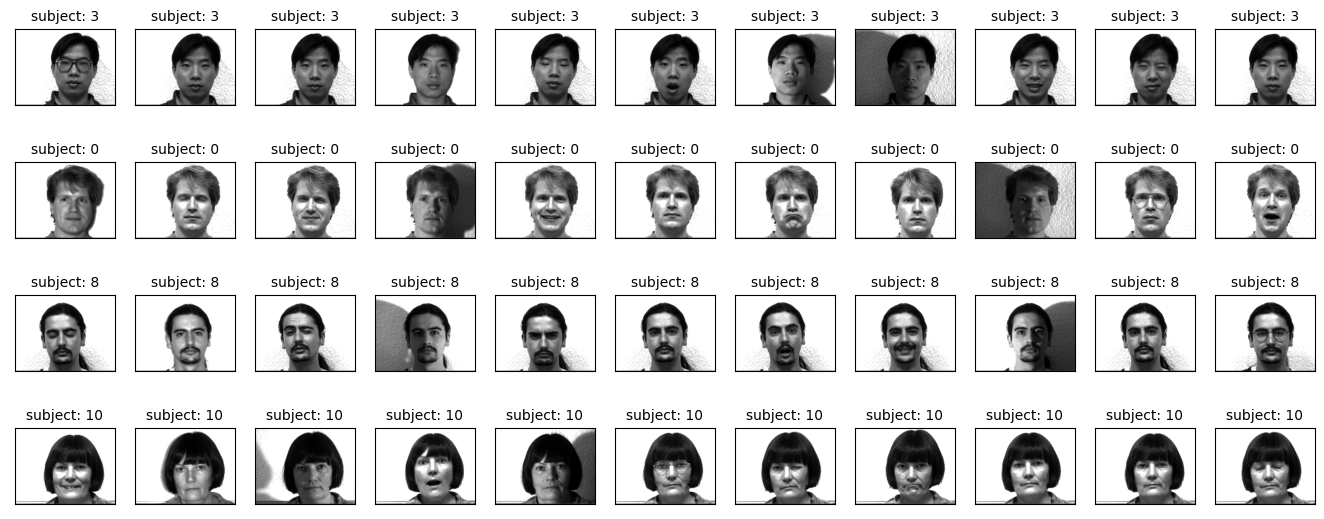

In [3]:
yalefaces.plot_subset(X, y, subjects=[3,0,8,10], num_samples=11)

## Dataset: analysis and pre-processing

### Image size and format

In [4]:
randomface = X[0]
# yalefaces.plot_face(randomface)

### Pixel importance from the Chi-squared score

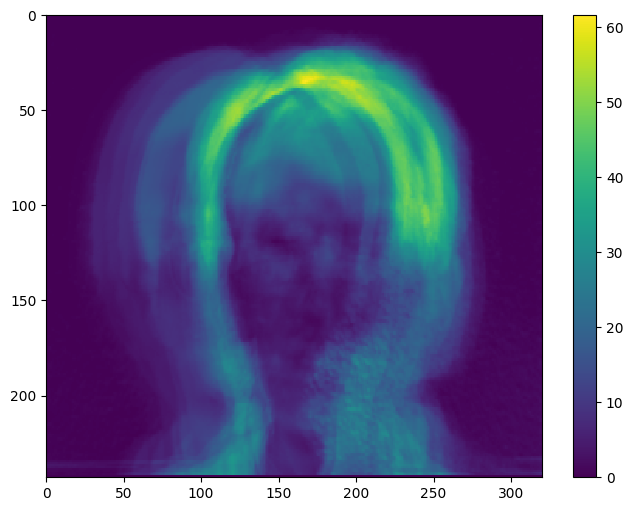

In [5]:
yalefaces.plot_pixel_importance(X, y)

### Image compression using Principal Component Analysis (PCA)
#### Compute eigenfaces using PCA

In [6]:
from sklearn.decomposition import PCA

num_faces, num_pixels = X.shape
num_principal_components = int(num_faces)

pca = PCA(n_components=num_principal_components)
pca.fit(X)

print(f"PCA generated {num_principal_components} eigenfaces of size {yalefaces.SHAPE}.")

PCA generated 165 eigenfaces of size (243, 320).


#### Plot eigenfaces (head, middle and tail)

<Figure size 640x480 with 0 Axes>

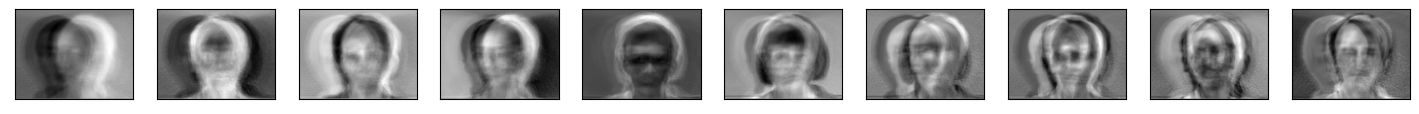

<Figure size 640x480 with 0 Axes>

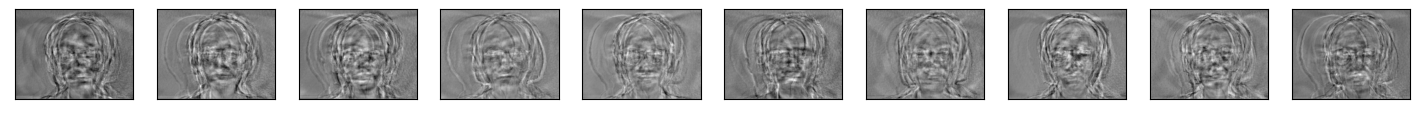

<Figure size 640x480 with 0 Axes>

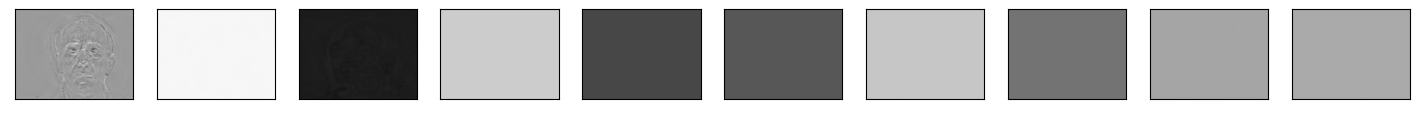

In [7]:
yalefaces.plot_eigenfaces(pca.components_[0:10])
yalefaces.plot_eigenfaces(pca.components_[80:90])
yalefaces.plot_eigenfaces(pca.components_[154:164])

#### Compress images using eigenfaces

In [8]:
X_compressed = pca.transform(X)

#### Compare original and compressed

<Figure size 640x480 with 0 Axes>

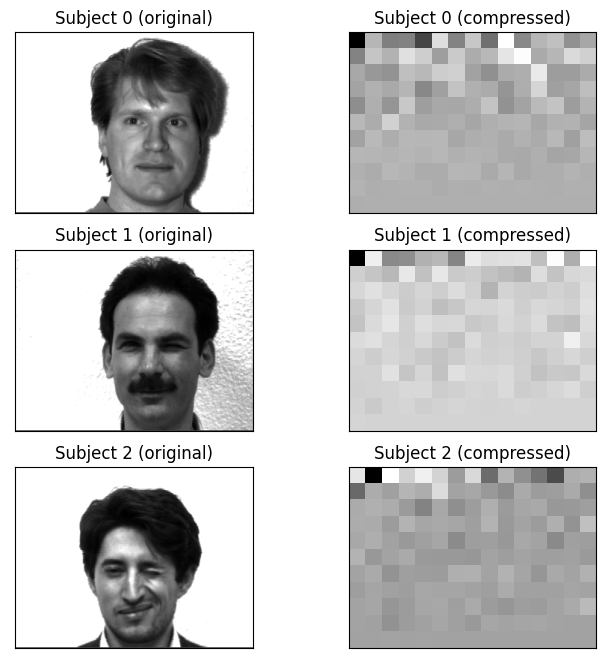

In [9]:
yalefaces.plot_compressed(X, X_compressed, y)

## Train MLP
### Use GPU if NVIDIA CUDA is available

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### Create train and test datasets

In [11]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

X_train = torch.Tensor(X_train_compressed)
y_train = torch.LongTensor(y_train_compressed)
train_dataset = TensorDataset(X_train, y_train)

X_test = torch.Tensor(X_test_compressed)
y_test = torch.LongTensor(y_test_compressed)
test_dataset = TensorDataset(X_test, y_test)

### Build a Multilayer Perceptron

In [12]:
from src.models.mlp import MLP
import torch.nn as nn

model = MLP(in_dim=165, out_dim=15, hidden_sizes=[96, 48], activation=nn.ReLU)
model = model.to(device)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [14]:
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, loss_fn=F.cross_entropy):
    model.train()

    epoch_loss = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # prepare
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # compute
        output = model(data)
        loss = loss_fn(output, target)

        # record
        epoch_loss += loss.item()
        n_samples += output.size(0)

        # adjust
        loss.backward()
        optimizer.step()

    return epoch_loss, n_samples

In [15]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [16]:
def test(model, device, test_loader):
    with torch.no_grad():
        model.train(False)
        num_correct = 0
        num_samples = 0

        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            scores = model.forward(x)
            _, y_out = scores.max(1)
            
            num_correct += (y_out == y).sum()
            num_samples += y_out.size(0)
        
        acc = float(num_correct) / float(num_samples)
    return acc

In [17]:
import numpy as np
from torch.utils.data import DataLoader

train_accs= []
train_losses = []

for epoch in range(200):
    # train
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
    err, n_train_samples = train(model, device, train_data, optimizer)
    loss = float(err)/float(n_train_samples)
    train_losses.append(loss)
    
    # evaluate
    acc = test(model, device, train_data)
    train_accs.append(acc)
    
    # log
    # print(f"\nEpoch: {epoch}\nLoss: {loss}\nAcc: {acc * 100:.2f}")


### Training loss

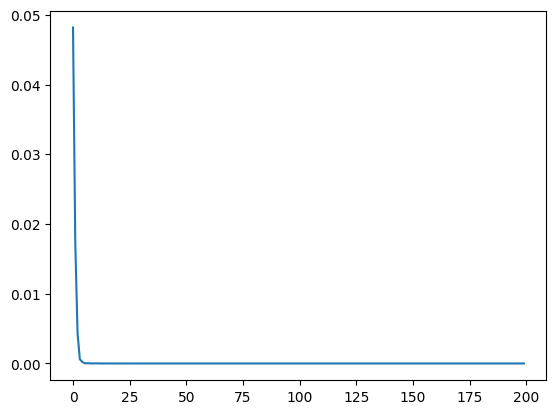

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses)

### Training accuracy

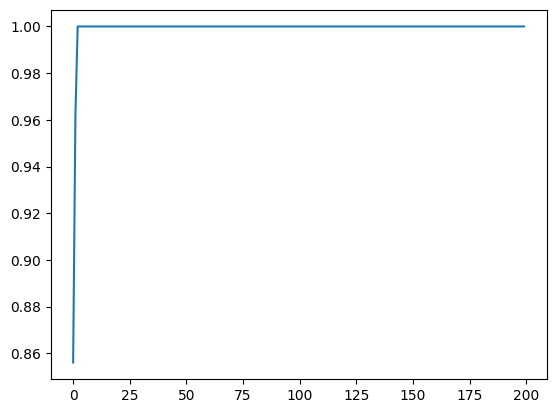

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_accs)

### Test accuracy

In [20]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")


Test accuracy: 84.85


## Quantize model
### Prepare model for quantization

Recover that our model has the following shape:

```python
model = nn.Sequential(
    nn.Linear(165, 96, bias=True),
    nn.ReLU(),
    nn.Linear(96, 48, bias=True),
    nn.ReLU(),
    nn.Linear(48, 15, bias=False)
)
```

In [21]:
import copy
import torch
from torch import nn

# copy our original model
qmodel_float = copy.deepcopy(model.net)
qmodel_float.eval()

# prepare layers
torch.quantization.fuse_modules(qmodel_float, ['0', '1'], inplace=True)
torch.quantization.fuse_modules(qmodel_float, ['2', '3'], inplace=True)

# add quantization layers for input and output
qmodel_float = nn.Sequential(
    torch.quantization.QuantStub(),
    *qmodel_float,
    torch.quantization.DeQuantStub()
)

### Configure quantization

In [22]:
qmodel_float.qconfig = torch.quantization.default_qconfig
qmodel_float=qmodel_float.to('cpu')

torch.quantization.prepare(qmodel_float, inplace=True)

Sequential(
  (0): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (1): LinearReLU(
    (0): Linear(in_features=165, out_features=96, bias=False)
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (2): Identity()
  (3): LinearReLU(
    (0): Linear(in_features=96, out_features=48, bias=False)
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (4): Identity()
  (5): Linear(
    in_features=48, out_features=15, bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (6): DeQuantStub()
)

### Try to quantize per tensor instead of per channel

In [23]:
print("Weight size before quantization:", qmodel_float[1][0].weight.element_size(), "byte(s)")

Weight size before quantization: 4 byte(s)


### Quantize network

In [24]:
# learn quantization parameters
with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(test_data):
        x,y = x.to('cpu'), y.to('cpu')
        qmodel_float(x)

# actually quantize weights
qmodel = torch.quantization.convert(qmodel_float, inplace=False)

In [25]:
print("Weight size after quantization:", qmodel[1].weight().element_size(), "byte(s)")

Weight size after quantization: 1 byte(s)


### Validate quantized model

In [26]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = test(qmodel, 'cpu', test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 84.85


### Compare model sizes

In [27]:
import os
import torch

def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.3f KB" %(os.path.getsize("tmp.pt")/1e3))
    os.remove('tmp.pt')

print_model_size(model)
print_model_size(qmodel)

86.051 KB
24.900 KB


## Export quantized model

### Floating- to fixed-point conversion algorithm

In [28]:
# scale=0.390065997838974, zero_point=59
s = 0.390065997838974
z = 59

# to be quantized: x
x = 73

qx = round((x/s)+z)
dqx = (qx-z)*s

print(f"Original: {x}")
print(f"Quantized: {qx}")
print(f"Dequantized: {dqx}")

Original: 73
Quantized: 246
Dequantized: 72.94234159588814


### Read weights and quantization parameters

In [45]:
layer_indexes = [1,3,5]

In [37]:
model_params=qmodel_float.state_dict()

In [38]:
model_params

OrderedDict([('0.activation_post_process.eps', tensor([1.1921e-07])),
             ('0.activation_post_process.min_val', tensor(-64.7021)),
             ('0.activation_post_process.max_val', tensor(89.3256)),
             ('1.0.weight',
              tensor([[-8.4587e-02,  2.4246e-02,  4.6623e-03,  ...,  8.3646e-09,
                        2.8371e-08,  1.7727e-08],
                      [ 7.1318e-02, -4.0298e-02, -2.0772e-02,  ...,  1.9545e-07,
                       -6.6303e-08,  5.7938e-08],
                      [ 2.7674e-02, -1.3156e-01, -8.8882e-02,  ..., -1.4037e-08,
                       -8.9576e-09, -1.3009e-08],
                      ...,
                      [ 9.6313e-02,  2.8740e-02, -2.0042e-02,  ..., -1.8305e-08,
                       -1.4996e-07, -7.6551e-08],
                      [-1.0360e-03, -1.1181e-02, -1.1508e-01,  ...,  9.3349e-08,
                        2.3943e-08, -8.5570e-08],
                      [-1.3100e-01,  7.4066e-02, -6.6860e-02,  ...,  7.1972e-09,


In [55]:
def get_layer_weights(layer_idx):
    if f'{layer_idx}.0.weight' in model_params.keys():
        weights = model_params[f'{layer_idx}.0.weight'].numpy()
    elif f'{layer_idx}.weight' in model_params.keys():
        weights = model_params[f'{layer_idx}.weight'].numpy()
    else:
        raise KeyError(f'{layer_idx}.0.weight or {layer_idx}.weight')
    return weights

def get_layer_min(layer_idx):
    return model_params[f'{layer_idx}.activation_post_process.min_val'].numpy()

def get_layer_max(layer_idx):
    return model_params[f'{layer_idx}.activation_post_process.max_val'].numpy()

### Export quantized weights

In [81]:
import numpy as np
with open('mlp_params.c', 'w') as source, open('mlp_params.h', 'w') as header:
    header.write('#ifndef MLP_PARAMS\n#define MLP_PARAMS\n\n')
    header.write('#include <stdint.h>\n\n\n')
    
    source.write('#include "mlp_params.h"\n\n')
    
    for layer in layer_indexes:
        weights = get_layer_weights(layer).flatten()
        amin = get_layer_min(layer)
        amax = get_layer_max(layer)
        
        header.write(f"extern const uint8_t layer_{layer}_weights[{len(weights)}];\n")
        
        # convert to fixed-point
        quant_max = 0
        quant_min = 255
        scale = (2*np.maximum(np.abs(amin), amax)) / (quant_max - quant_min)
        zero = amin
        eps=1.1921e-07

        print(f"scale={scale}, min={amin}, max={amax}")
        
        # FIXME: convertion is not working properly yet...
        weights_fp = (np.around((weights * scale) + zero)).astype(int)
        # weights_fp = (w - zero) * scale # this should be the reverse operation actually...

        source.write(f"const uint8_t layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights_fp[i]}, ")
        source.write(f"{weights_fp[len(weights)-1]};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')

        

scale=-0.1369733922621783, min=0.0, max=17.464107513427734
0.0
scale=-0.24307400572533702, min=0.0, max=30.99193572998047
0.0
scale=-0.21419109269684436, min=-27.309364318847656, max=24.78845977783203
27.309364
